In [25]:
import torch.nn as nn
import torch
import torch.utils.data as data
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import os
import scipy.io as sio
from collections import defaultdict, deque
import datetime
import time
import torch.distributed as dist
import errno
import torch.nn.functional as F
import math
import random
from matplotlib import pyplot as plt
from torchvision import transforms

In [26]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{value:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [29]:
# transform
def transform_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return transform

# create dataset class
class channel_dataset(data.Dataset):
    def __init__(self, data_path, use_noise: bool = False, is_train: bool = True):
        super(channel_dataset, self).__init__()
        self.data_path = data_path
        self.data = sio.loadmat(data_path)
        self.use_noise = use_noise
        self.is_train = is_train

        self.trans = transform_data()

        self.signals = self.data['filter_outputs'][:80000, :] if is_train else self.data['filter_outputs']
        self.symbols = self.data['qam_symbols'][:, :80000] if is_train else self.data['qam_symbols']
        self.symbols = np.reshape(self.symbols, (-1))

        if use_noise:
            noise = np.random.randint(-2, 3, size=self.signals.shape).astype(np.uint8)
            self.signals += noise

        self.signals = np.reshape(self.signals, (-1, 8, 16, 1)).astype(np.uint8)

        self.num_samples = self.signals.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return torch.tensor(self.symbols[index]).to(torch.long), self.trans(self.signals[index])

In [30]:
class Detector_CNN(nn.Module):
    def __init__(self, output_size: int = 4):
        super(Detector_CNN, self).__init__()
        self.output_size = output_size

        # (B, 1, 8, 16) -> (B, 16, 2, 4)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.Flatten(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(2 * 4 * 16, 128),
            nn.ReLU(),
            # nn.Linear(128, 128),
            # nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
        )

    def forward(self, signal_in):
        return self.mlp(self.cnn(signal_in))

class Detector_MLP(nn.Module):
    def __init__(self, output_size: int = 4):
        super(Detector_MLP, self).__init__()
        self.output_size = output_size

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
        )

    def forward(self, signal_in):
        return self.mlp(signal_in)

In [31]:
def quantize_regularize(model, device, alpha=0.01, interval=0.05):
    central_params = torch.arange(0.0, 1+interval, interval).to(device)
    reg_params = {}
    for c in central_params:
        if c == 0.0:
            reg_params[c] = [p.abs() < interval / 2 for n, p in model.named_parameters()]
        if c == 1.0:
            reg_params[c] = [p.abs() > 1 - interval / 2 for n, p in model.named_parameters()]
        else:
            reg_params[c] = [(c - interval / 2 <= p.abs()) & (p.abs() < c + interval / 2) for n, p in model.named_parameters()]

    reg_loss = 0.0
    for c, params in reg_params.items():
        reg_loss += alpha * torch.sum(torch.stack([torch.sum((p[params[i]].abs() - c).abs()) for i, (n, p) in enumerate(model.named_parameters())]))

    return reg_loss

# train one epoch
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler):
    model.train()
    metric_logger = MetricLogger(delimiter="    ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for symbols, signals in metric_logger.log_every(data_loader, print_freq, header):
        symbols, signals = symbols.to(device), signals.to(device).to(torch.float)

        with torch.amp.autocast('cuda'):
            # equalized_output = model(tx_pilot, rx_pilot, rx_input)
            output = model(signals)
            loss = F.cross_entropy(output, symbols)

            if epoch >= 10:
                loss += quantize_regularize(model, device)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        # calculate binary accuracy
        output_bits = torch.argmax(output, dim=-1)
        accuracy = (output_bits == symbols).float().mean()
        
        metric_logger.update(loss=loss, lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(accuracy=accuracy)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

def evaluate(model, data_loader, device, epoch, print_freq):
    model.eval()
    metric_logger = MetricLogger(delimiter="    ")
    header = 'Test: Epoch: [{}]'.format(epoch)

    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            for symbols, signals in metric_logger.log_every(data_loader, print_freq, header):
                symbols, signals = symbols.to(device), signals.to(device).to(torch.float)

                output = model(signals)
                loss = F.cross_entropy(output, symbols)

                # calculate binary accuracy
                output_bits = torch.argmax(output, dim=-1)
                accuracy = (output_bits == symbols).float().mean()
                
                metric_logger.update(loss=loss)
                metric_logger.update(accuracy=accuracy)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [32]:
def main(snr, mode, cnn, noise):
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    # set seed
    torch.manual_seed(42)
    np.random.seed(42)

    batch_size = 512
    num_epoch = 100
    lr = 0.001
    lrf = 0.1

    train_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/filtered_data.mat"
    val_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/filtered_data.mat"

    train_dataset = channel_dataset(train_data_path, use_noise=noise, is_train=True)
    val_dataset = channel_dataset(val_data_path, use_noise=noise, is_train=False)

    train_sampler = data.RandomSampler(train_dataset)
    val_sampler = data.SequentialSampler(val_dataset)

    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, drop_last=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    out_size = 4 if mode != 'qam16' else 16
    
    model = Detector_CNN(output_size=out_size).to(device) if cnn else Detector_MLP(output_size=out_size).to(device)

    params_to_optimize = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params_to_optimize, lr=lr)
    scaler = torch.amp.GradScaler('cuda')

    lf = lambda x: ((1 + math.cos(x * math.pi / num_epoch)) / 2) * (1 - lrf) + lrf
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    scheduler.last_epoch = 0

    best_loss, best_epoch = math.inf, 0
    start_time = time.time()
    for epoch in range(num_epoch):
        train_dict = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=200, scaler=scaler)
        val_dict = evaluate(model, val_loader, device, epoch, print_freq=200)
        scheduler.step()

        if epoch >= 20 and val_dict['loss'] < best_loss:
            best_loss = val_dict['loss']
            best_epoch = epoch
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch
            }
            torch.save(save_file, "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/best_detection_model.pth")
            print("Save model from: ", epoch)

    print("Total time: {}s".format(int(time.time() - start_time)))
    print("Best loss: {}".format(best_loss), ";  Best Epoch: {}".format(best_epoch))

    # min, max of the model parameters
    min_params, max_params = [], []
    for p in model.parameters():
        min_params.append(p.min().item())
        max_params.append(p.max().item())
    min_params, max_params = np.min(min_params), np.max(max_params)
    print(f"Min of model parameters: {min_params}, Max of model parameters: {max_params}")
    # plot histogram of model parameters
    params = [p.detach().cpu().numpy().flatten() for p in model.parameters()]
    plt.hist(np.hstack(params), bins=100)
    plt.show()

    return

In [33]:
cnn = True
noise = True

snr = 5
mode = 'qam4'  # pam4 qam4 qam16 psk4

Epoch: [0]    [  0/156]    eta: 0:00:06    lr: 0.001000    loss: 1.3882 (1.3882)    accuracy: 0.2285 (0.2285)    time: 0.0426    data: 0.0380    max mem: 22
Epoch: [0] Total time: 0:00:06
Averaged stats: lr: 0.001000    loss: 0.0001 (0.5428)    accuracy: 1.0000 (0.7490)
Test: Epoch: [0]    [  0/192]    eta: 0:00:07    loss: 0.0185 (0.0185)    accuracy: 0.9980 (0.9980)    time: 0.0369    data: 0.0361    max mem: 22
Test: Epoch: [0] Total time: 0:00:06
Averaged stats: loss: 0.0001 (0.0002)    accuracy: 1.0000 (1.0000)
Epoch: [1]    [  0/156]    eta: 0:00:06    lr: 0.001000    loss: 0.0001 (0.0001)    accuracy: 1.0000 (1.0000)    time: 0.0394    data: 0.0363    max mem: 22
Epoch: [1] Total time: 0:00:05
Averaged stats: lr: 0.001000    loss: 0.0000 (0.0002)    accuracy: 1.0000 (1.0000)
Test: Epoch: [1]    [  0/192]    eta: 0:00:07    loss: 0.0207 (0.0207)    accuracy: 0.9980 (0.9980)    time: 0.0372    data: 0.0365    max mem: 22
Test: Epoch: [1] Total time: 0:00:07
Averaged stats: loss: 0

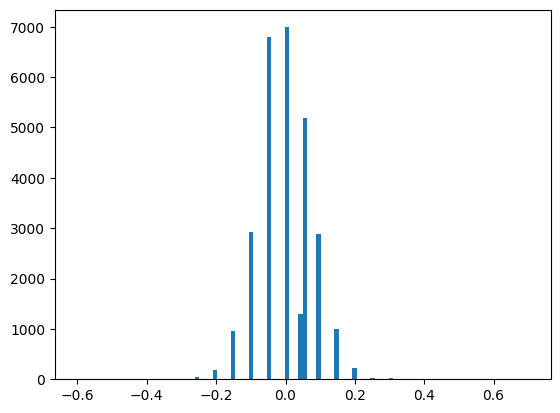

In [36]:
main(snr, mode, cnn, noise)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_size = 4 if mode != 'qam16' else 16

model = Detector_CNN(output_size=out_size).to(device) if cnn else Detector_MLP(output_size=out_size).to(device)
model_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/best_detection_model.pth"
ckpt = torch.load(model_path)['model']
# for n, p in ckpt.items():
#     print(n, p.shape)
model.load_state_dict(ckpt)
model.eval()

val_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/filtered_data.mat"
val_dataset = channel_dataset(val_data_path, use_noise=noise, is_train=False)
val_sampler = data.SequentialSampler(val_dataset)
val_loader = data.DataLoader(val_dataset, batch_size=64, sampler=val_sampler, drop_last=False)

dummy_input = torch.randn(1, 1, 8, 16).to(device)
torch.onnx.export(model, dummy_input,
                  "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/symbol_detection.onnx",
                  export_params=True, opset_version=16, dynamic_axes={'input': {0: 'batch_size'}, 'sensor_out': {0: 'batch_size'}},
                  input_names=['input'], output_names=['sensor_out'])

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_size = 4 if mode != 'qam16' else 16

model = Detector_CNN(output_size=out_size).to(device) if cnn else Detector_MLP(output_size=out_size).to(device)
model_path = "./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/best_detection_model.pth"
ckpt = torch.load(model_path)['model']
# for n, p in ckpt.items():
#     print(n, p.shape)
model.load_state_dict(ckpt)
model.eval()

train_data_path = "./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/shuffle/filtered_data_train.mat"
val_data_path = "./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/shuffle/filtered_data_val.mat"

train_dataset = channel_dataset(train_data_path, use_noise=noise, is_train=True)
val_dataset = channel_dataset(val_data_path, use_noise=noise, is_train=False)

train_sampler = data.SequentialSampler(train_dataset)
val_sampler = data.SequentialSampler(val_dataset)

train_loader = data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler, drop_last=False)
val_loader = data.DataLoader(val_dataset, batch_size=64, sampler=val_sampler, drop_last=False)

simulate_outputs = []
true_symbols = []

with torch.no_grad():
    with torch.amp.autocast('cuda'):
        for symbols, signals in train_loader:
            symbols, signals = symbols.to(device), signals.to(device).to(torch.float)

            output = model(signals)

            true_symbols.append(symbols.detach().cpu().numpy())
            simulate_outputs.append(output.detach().cpu().numpy())

with torch.no_grad():
    with torch.amp.autocast('cuda'):
        for symbols, signals in val_loader:
            symbols, signals = symbols.to(device), signals.to(device).to(torch.float)

            output = model(signals)

            true_symbols.append(symbols.detach().cpu().numpy())
            simulate_outputs.append(output.detach().cpu().numpy())

simulate_outputs = np.concatenate(simulate_outputs, 0)  # (B, 4)
true_symbols = np.concatenate(true_symbols, 0)  # (B,)

HW_data_path = "./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/hw_out_" + str(snr) +"db_" + mode + ".npy"
HW_data = np.load(HW_data_path)  # (B, 4)

simulate_acc = (np.argmax(simulate_outputs, -1) == true_symbols).mean()
HW_acc = (np.argmax(HW_data, -1) == true_symbols).mean()

print(simulate_acc, HW_acc)

0.9962128812199037 0.9960623996789727


In [24]:
HW_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/symbol_img_hw_out_5db_qam4.npy"
HW_data = np.load(HW_data_path)  # (B, 4)
HW_data = np.argmax(HW_data, 1)
print(HW_data.shape)
path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/symbol_img_hw_out_5db_qam4.mat"
data_dict = {
    "HW_data": HW_data
}
sio.savemat(path, data_dict)

(21264,)
